# Importing Libraries and getting url

In [1]:
!pip install graphviz
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import precision_score, recall_score, accuracy_score 
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.externals.six import StringIO  
from sklearn.dummy import DummyClassifier
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pandas as pd 
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
url='http://strainapi.evanbusse.com/80Bxz5h/strains/search/all'
response=requests.get(url)

In [2]:
dat=response.json()

# Functions

In [3]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        if accuracy > best_score:
            best_k = k
            best_score = accuracy
    print("Best Value for k: {}".format(best_k))
    print("Accuracy: {}".format(best_score))

    
def print_metrics(test, preds):
    print("Precision Score: {}".format(precision_score(test, preds,average=None)))
    print("Recall Score: {}".format(recall_score(test, preds,average=None)))
    print("Accuracy Score: {}".format(accuracy_score(test, preds)))
    print("F1 Score: {}".format(f1_score(test, preds,average=None)))
    
def roc(classifier):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score=classifier.fit(X_train, y_train).predict(X_test)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

## Creating Effects & Types DataFrame

In [4]:
names=list(dat.keys())
positive,negative,medical,posi,neg,med,eff,tye=[],[],[],[],[],[],[],[]
for n in names:
    tye.append(dat[n]['race'])
    eff.append(dat[n]['effects']['positive']+dat[n]['effects']['negative']+dat[n]['effects']['medical'])
    positive.append(dat[n]['effects']['positive'])
    posi.append(len(dat[n]['effects']['positive']))
    negative.append(dat[n]['effects']['negative'])
    neg.append(len(dat[n]['effects']['negative']))
    medical.append(dat[n]['effects']['medical'])
    med.append(len(dat[n]['effects']['medical']))
dic={'name':names,'type':tye,'effects':eff}
df=pd.DataFrame(dic)
df

,name,type,effects
0,Afpak,hybrid,"[Relaxed, Hungry, Happy, Sleepy, Dizzy, Depres..."
1,African,sativa,"[Euphoric, Happy, Creative, Energetic, Talkati..."
2,Afternoon Delight,hybrid,"[Relaxed, Hungry, Euphoric, Uplifted, Tingly, ..."
3,Afwreck,hybrid,"[Relaxed, Happy, Creative, Uplifted, Sleepy, D..."
4,Agent Orange,hybrid,"[Relaxed, Euphoric, Happy, Energetic, Uplifted..."
5,Agent Tangie,hybrid,"[Euphoric, Happy, Creative, Uplifted, Focused,..."
6,Alaska,sativa,"[Relaxed, Euphoric, Happy, Energetic, Focused,..."
7,Alaska Thunder Grape,hybrid,"[Relaxed, Euphoric, Creative, Tingly, Focused,..."
8,Alaskan Ice,sativa,"[Euphoric, Happy, Creative, Energetic, Uplifte..."
9,Alaskan Thunder Fuck,sativa,"[Relaxed, Euphoric, Happy, Energetic, Uplifted..."


## Cleaning up dataframe, creating dummy columns for all effects

In [5]:
effects=[]
pos=list(eff)
for p in pos:
    for i in p:
        if i not in effects:
            effects.append(i)
for i in effects:
    title=str(i)
    title=[]
    for x in df['effects']:
        if i in x:
            title.append(1)
        else:
            title.append(0)
    df[i]=title

## Get dummies for type (indica=0,sativa=1,hybrid=2)
### Engineer features for positive effect score, negative effect score, and medical effect score

In [6]:
df.drop(columns='effects',inplace=True)
df.type=df.type.map({'indica':0,'sativa':1,'hybrid':2})
lowers=[]
for n in df['name']:
    lowers.append(n.lower())
df['name']=lowers
df['positive']=posi
df['negative']=neg
df['medical']=med
df.head()

,name,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,...,Eye Pressure,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical
0,afpak,2,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,4,1,5
1,african,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,5,1,6
2,afternoon delight,2,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,5,3,6
3,afwreck,2,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,5,4,6
4,agent orange,2,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,5,4,6


# Scraping THC content data

In [7]:
namelist,typelist,thclist=[],[],[]
for i in range(1,62):
    response=requests.get('https://www.wikileaf.com/strains/?page={}'.format(i))
    soup=BeautifulSoup(response.content,'html.parser')
    names=soup.findAll('h5',{'class':'name disp-title'})
#     types=soup.findAll('p',{'class':'tag'})
    thcs=soup.findAll('p',{'class':'desc'})
    for n,x in zip(names,thcs):
        namelist.append(n.text.lower())
#         typelist.append(t.text.lower())
        thclist.append(int(x.text[3:6].strip('%')))

In [8]:
moreinfo={'name':namelist,'thc':thclist}
df3=pd.DataFrame(moreinfo)
fulldf=pd.merge(df,df3,on='name')
fulldf.sort_values('thc',inplace=True)
fulldf.reset_index(inplace=True)
fulldf.drop(columns='index',inplace=True)
fulldf

,name,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,madagascar,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,5,3,5,0
1,four cups,2,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,5,1,5,0
2,eastern european,0,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,3,1,5,0
3,deep cheese,2,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,5,3,4,0
4,north indian,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,5,2,4,0
5,tahoe hydro champagne,2,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,5,1,3,0
6,ocd,1,0,0,0,0,1,1,0,1,...,0,1,1,0,0,1,5,4,5,0
7,white slipper,2,1,0,1,0,0,1,0,1,...,1,0,0,0,0,0,5,1,5,0
8,majestic 12,2,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,4,1,4,0
9,jelly roll,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,3,2,4,0


## Looking for class imbalance

Probability of Indica: 0.2823871906841339
Probability of Sativa: 0.19796215429403202
Probability of Hybrid: 0.519650655021834


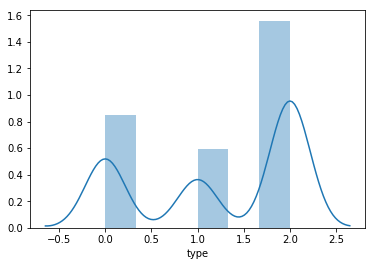

In [196]:
indicadf=fulldf[fulldf['type']==0]
sativadf=fulldf[fulldf['type']==1]
hybriddf=fulldf[fulldf['type']==2]

sns.distplot(fulldf['type'])
prind=len(indicadf)/len(fulldf)
prsat=len(sativadf)/len(fulldf)
prhyb=len(hybriddf)/len(fulldf)
print('Probability of Indica: {}'.format(prind))
print('Probability of Sativa: {}'.format(prsat))
print('Probability of Hybrid: {}'.format(prhyb))

## Train Test Split

In [145]:
features=fulldf.drop(columns=['name','type'])
target=label_binarize(fulldf.type,classes=[0,1,2])
n_classes=targetd.shape[1]

X_train, X_test, y_train, y_test = train_test_split(featuresd, targetd, test_size=0.25)

## Scale Training Features

In [147]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns=features.columns)
scaled_df_train.head()

,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,Stress,Lack of Appetite,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,0.5,-0.510598,-2.510969,-0.651628,-0.950727,-2.123210,-0.907198,0.498483,0.322437,1.375957,...,1.469527,-0.361422,-0.242037,2.10944,-0.137089,-0.093888,-1.400869,0.808019,-0.069690,-1.324853
1,0.5,1.958489,-2.510969,1.534617,1.051827,0.470985,-0.907198,0.498483,0.322437,-0.726767,...,-0.680491,-0.361422,-0.242037,2.10944,-0.137089,-0.093888,-1.400869,0.808019,0.862523,-0.711826
2,-2.0,-0.510598,0.398253,-0.651628,1.051827,0.470985,-0.907198,0.498483,0.322437,-0.726767,...,-0.680491,-0.361422,-0.242037,-0.47406,-0.137089,-0.093888,0.423271,0.808019,0.862523,-0.916168
3,0.5,-0.510598,0.398253,-0.651628,1.051827,0.470985,-0.907198,0.498483,0.322437,1.375957,...,-0.680491,-0.361422,-0.242037,-0.47406,-0.137089,-0.093888,0.423271,0.808019,0.862523,-0.303141
4,0.5,1.958489,0.398253,-0.651628,-0.950727,0.470985,1.102295,0.498483,0.322437,-0.726767,...,-0.680491,-0.361422,-0.242037,-0.47406,-0.137089,-0.093888,0.423271,-0.980505,-0.069690,0.514229


## Scale all data

In [209]:
scaleddf= scaler.fit_transform(fulldf.drop(columns='name'))

scaleddf = pd.DataFrame(scaleddf, columns=fulldf.drop(columns='name').columns)

38

## Converting types

In [227]:
for i in fulldf['type']:
    i=float(i)
relax=[]
for i in fulldf['Relaxed']:
    relax.append(float(i))

## Looking at differences in effects among classes

IndexError: index 0 is out of bounds for axis 1 with size 0

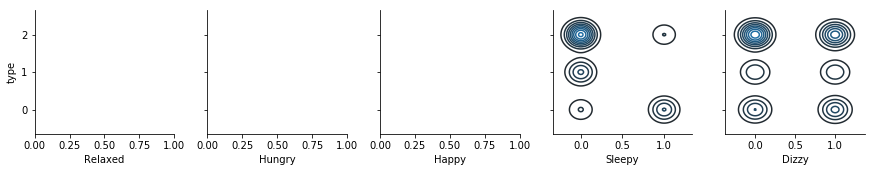

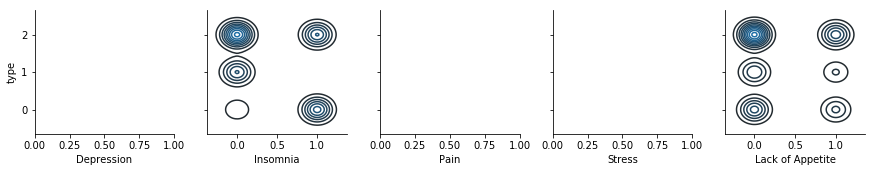

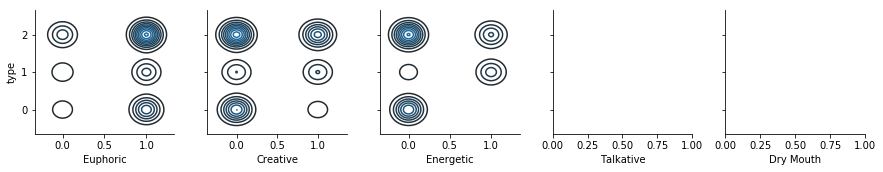

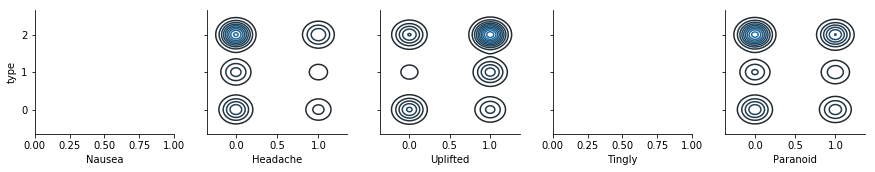

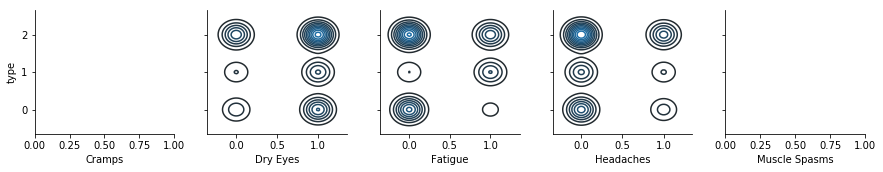

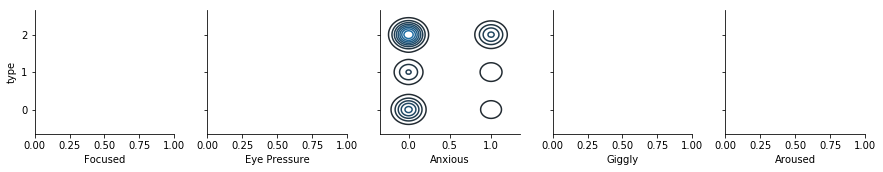

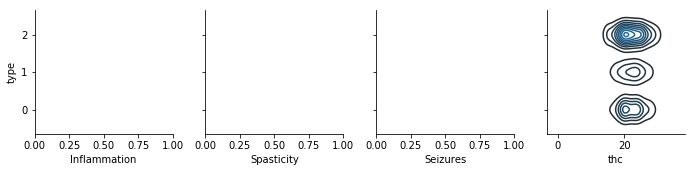

<Figure size 0x180 with 0 Axes>

In [224]:
for i in range(0, 38, 5):
    g = sns.PairGrid(fulldf,
                     x_vars = effects[i:i+5],
                     y_vars = ['type'])
    g = g.map(sns.kdeplot)

## Looking at distributions of each effect before and after scaling

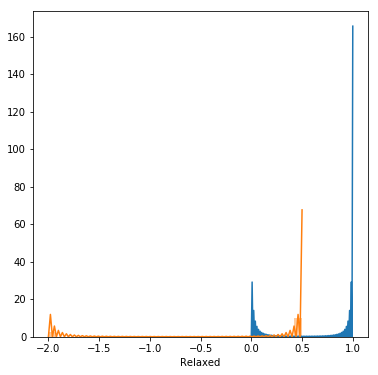

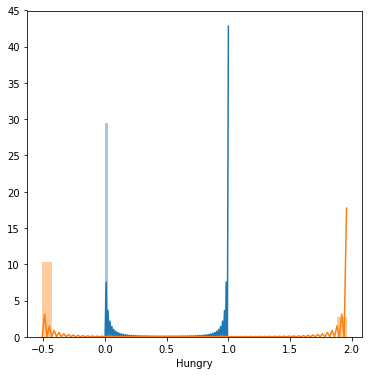

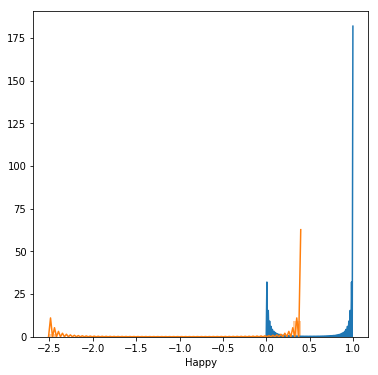

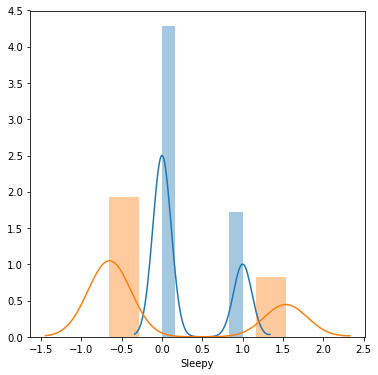

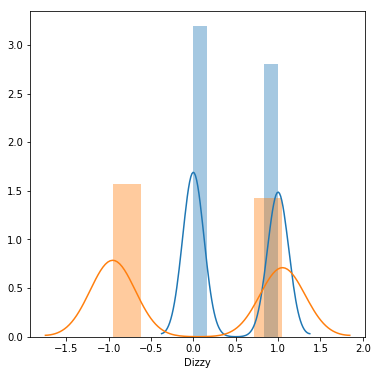

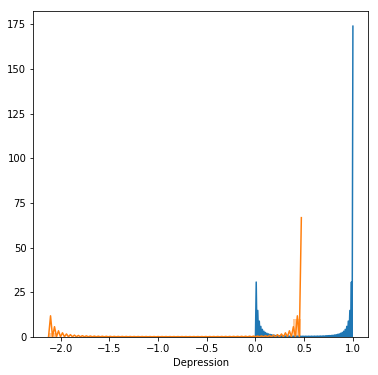

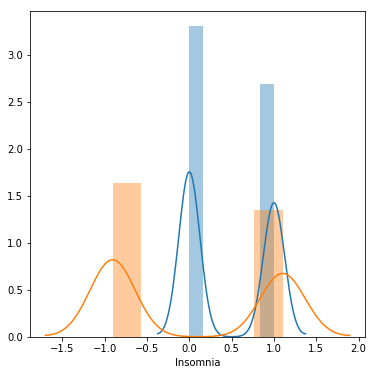

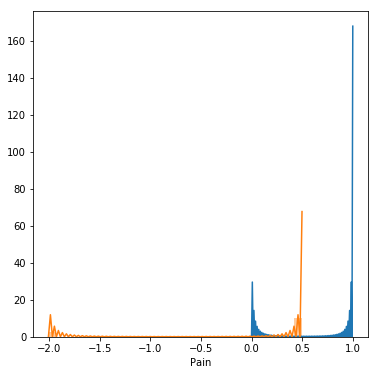

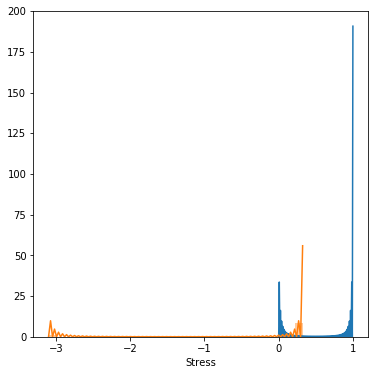

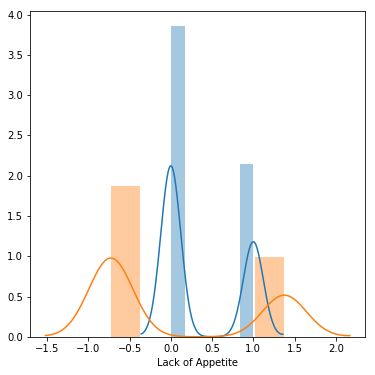

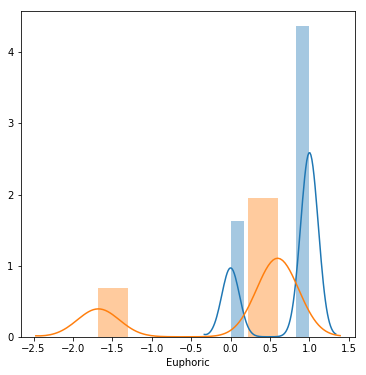

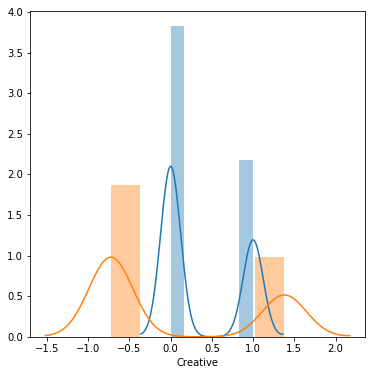

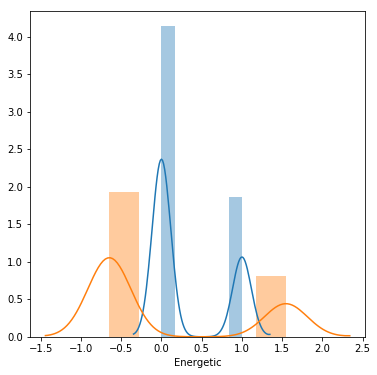

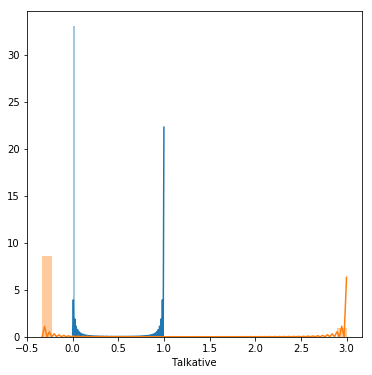

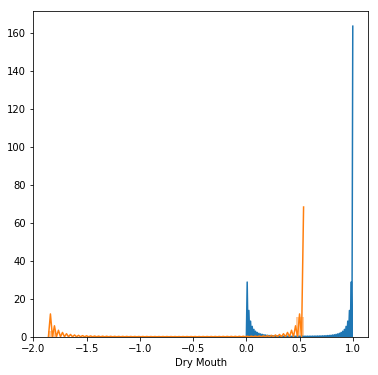

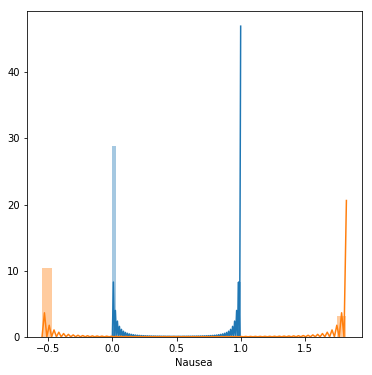

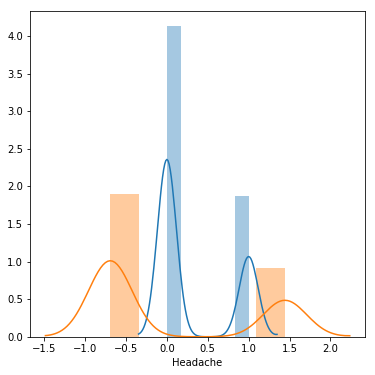

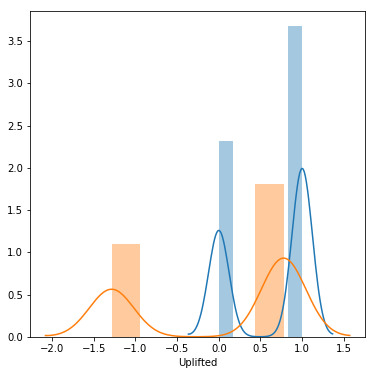

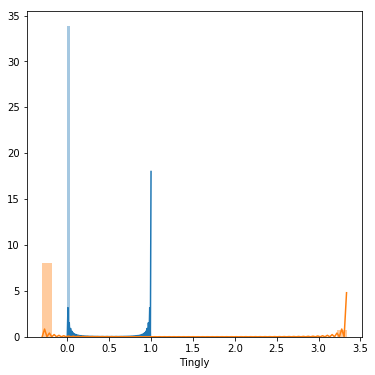

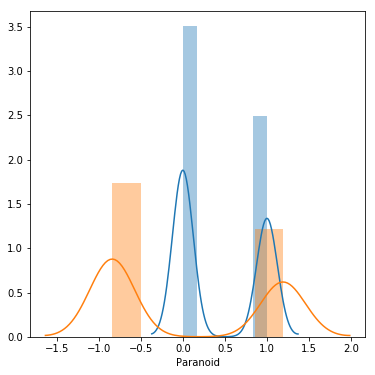

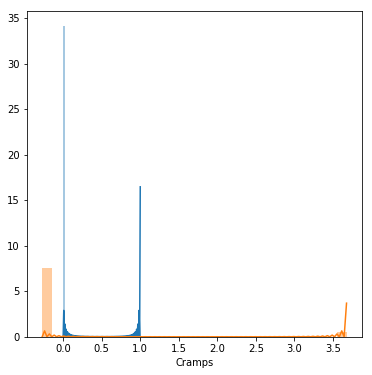

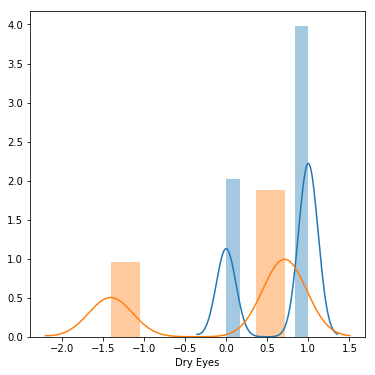

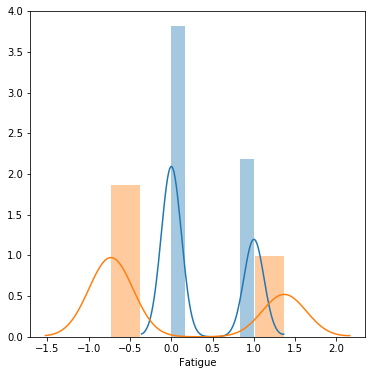

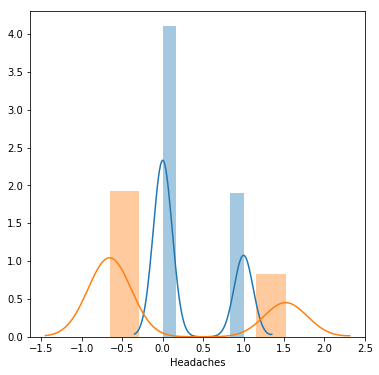

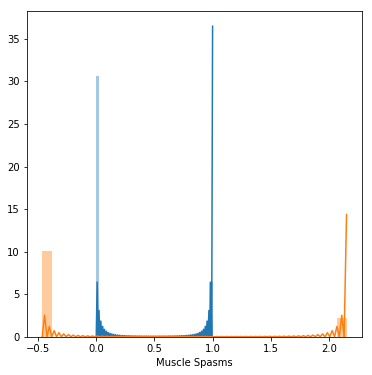

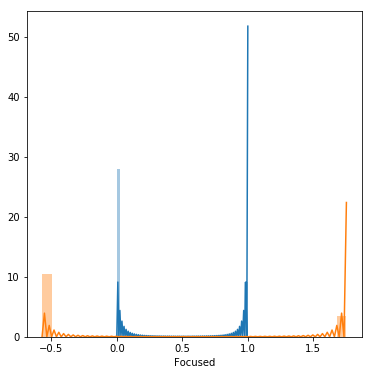

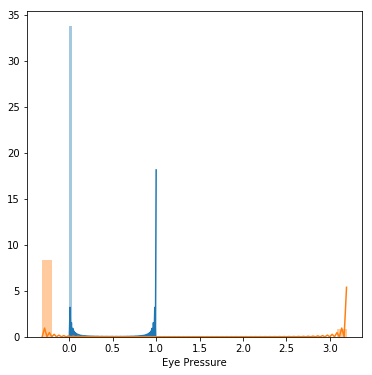

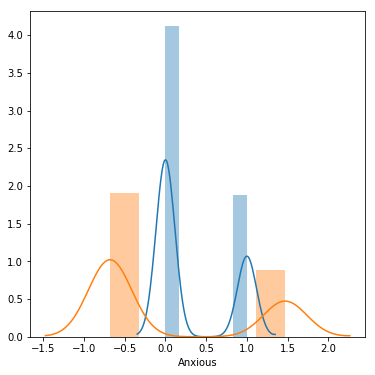

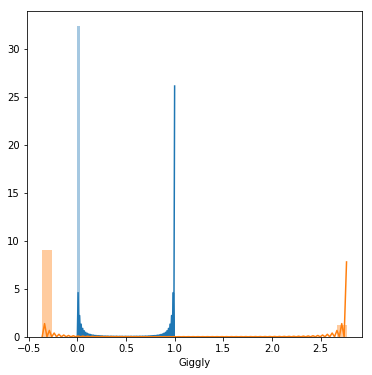

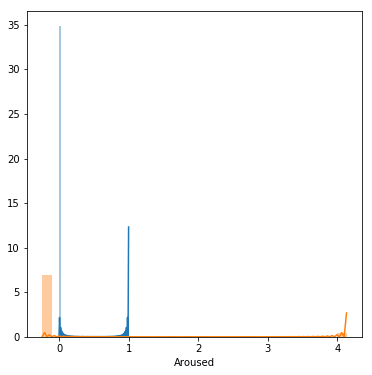

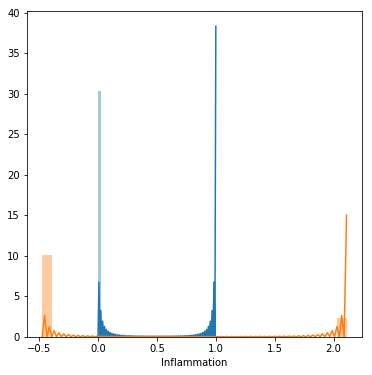

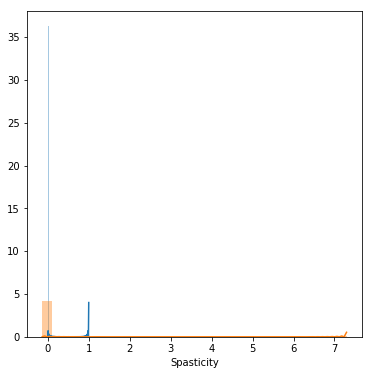

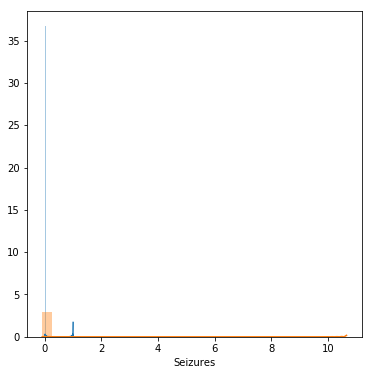

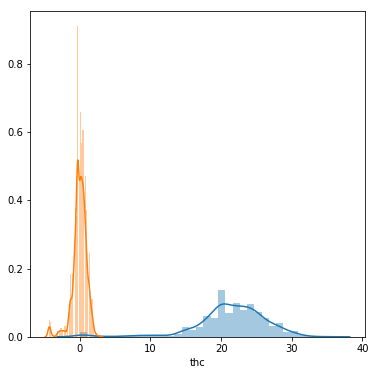

In [151]:
effects.append('thc')
for e in effects:
    plt.figure(figsize=(6,5))
    sns.distplot(fulldf[e])
    sns.distplot(scaled_df_train[e])

## Examining different kinds of effects v. thc content

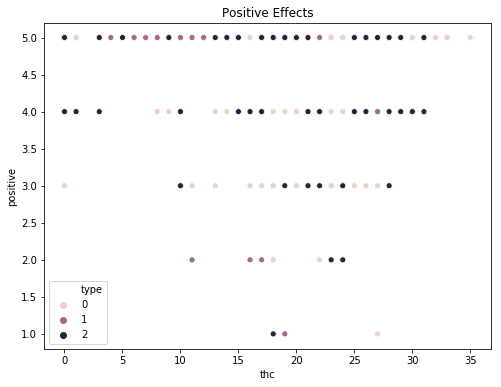

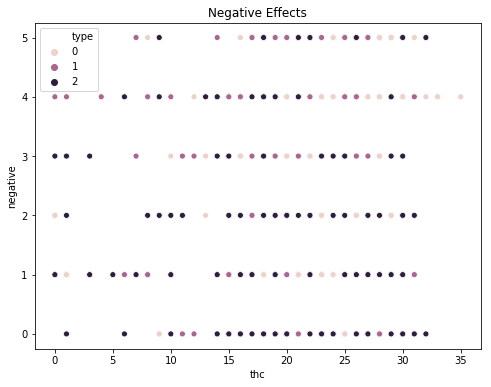

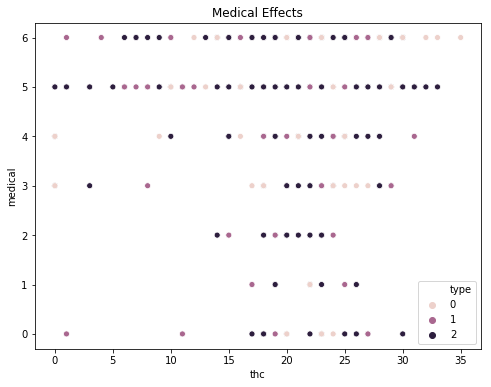

In [152]:
plt.figure(figsize=(8,6))
plt.title('Positive Effects')
sns.scatterplot(x='thc',y='positive',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Negative Effects')
sns.scatterplot(x='thc',y='negative',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Medical Effects')
sns.scatterplot(x='thc',y='medical',hue='type',data=fulldf)

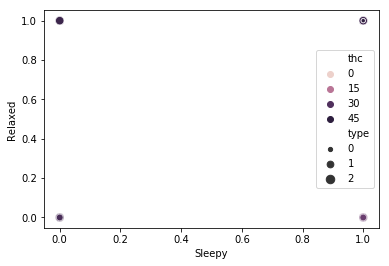

In [124]:
sns.scatterplot(x='Sleepy',y='Relaxed',hue='thc',alpha=0.8,size='type',data=fulldf)

# Beginning Modeling

## Baseline Model: Most Probable to be Hybrid, so Predict All as Hybrid

In [153]:
dummy = DummyClassifier(strategy='uniform', random_state=1)

dummy.fit(X_train, y_train)
basepreds=dummy.predict(scaled_data_test)
sc=dummy.score(X_test, y_test) 
print("Baseline Model Metrics:")
print_metrics(y_test,basepreds)

Baseline Model Metrics:
Precision Score: [0.27118644 0.21768707 0.47093023]
Recall Score: [0.49484536 0.41558442 0.47647059]
Accuracy Score: 0.10465116279069768
F1 Score: [0.35036496 0.28571429 0.47368421]


## KNN Base Model

In [154]:
clf1 = KNeighborsClassifier()
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)

In [155]:
print_metrics(y_test, test_preds)

Precision Score: [0.64102564 0.55319149 0.57978723]
Recall Score: [0.51546392 0.33766234 0.64117647]
Accuracy Score: 0.5377906976744186
F1 Score: [0.57142857 0.41935484 0.60893855]


#### Accuracy KNN Base Model: 0.3401

##### Accuracy increases by 0.1977 from Baseline Model

## Getting best KNN model

In [156]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 15
Accuracy: 0.5668604651162791


In [158]:
clf1 = KNeighborsClassifier(n_neighbors=15)
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)

Precision Score: [0.67567568 0.75       0.59605911]
Recall Score: [0.51546392 0.31168831 0.71176471]
Accuracy Score: 0.5668604651162791
F1 Score: [0.58479532 0.44036697 0.64879357]


#### Accuracy Best KNN Model: 0.6279
##### "Best" KNN Model 6.27% more accuracte than base KNN model

## Decision Tree

## Baseline Decision Tree

In [160]:
classifier1 = DecisionTreeClassifier()  
classifier1.fit(X_train, y_train) 
y_predd = classifier1.predict(X_testd) 

In [161]:
y_scored = classifier1.score(X_testd, y_testd)
print('Accuracy: ', y_scored)

# Compute the average precision score
micro_precision = precision_score(y_predd, y_testd, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_predd, y_testd, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_predd, y_testd, average=None)
print('Per-class precision score:', per_class_precision)

Accuracy:  0.8924418604651163
Micro-averaged precision score: 0.89
Macro-averaged precision score: 0.88
Per-class precision score: [0.85263158 0.85714286 0.92473118]


In [162]:
print_metrics(y_testd,y_predd)

Precision Score: [0.91011236 0.85714286 0.89583333]
Recall Score: [0.85263158 0.85714286 0.92473118]
Accuracy Score: 0.8924418604651163
F1 Score: [0.88043478 0.85714286 0.91005291]


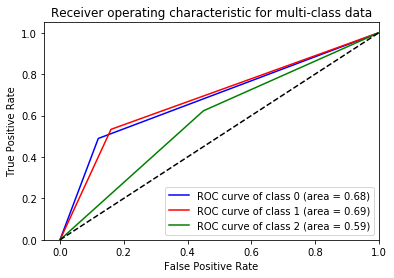

In [165]:
roc(classifier1)

In [166]:
classifier2 = DecisionTreeClassifier(random_state=10)  
classifier2.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [167]:
y_pred = classifier2.predict(X_test) 

In [168]:
y_score = classifier2.score(X_test, y_test)
print('Accuracy: ', y_score)

# Compute the average precision score
from sklearn.metrics import precision_score
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

Accuracy:  0.5465116279069767
Micro-averaged precision score: 0.55
Macro-averaged precision score: 0.52
Per-class precision score: [0.44680851 0.49333333 0.62285714]


In [169]:
print_metrics(y_test,y_pred)

Precision Score: [0.56       0.4625     0.57671958]
Recall Score: [0.44680851 0.49333333 0.62285714]
Accuracy Score: 0.5465116279069767
F1 Score: [0.49704142 0.47741935 0.5989011 ]


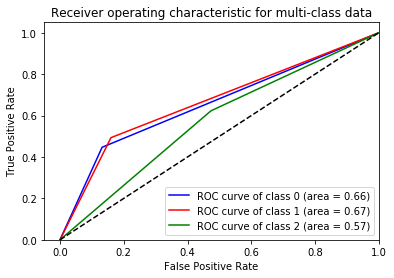

In [170]:
roc(classifier2)

In [171]:
classifier3 = DecisionTreeClassifier(criterion='entropy',random_state=10)  
classifier3.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [172]:
y_pred = classifier3.predict(X_test) 

In [173]:
print_metrics(y_test,y_pred)

Precision Score: [0.65333333 0.4        0.56613757]
Recall Score: [0.5212766  0.42666667 0.61142857]
Accuracy Score: 0.5465116279069767
F1 Score: [0.57988166 0.41290323 0.58791209]


In [174]:
acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

# Check the AUC for predictions
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
# print('\nConfusion Matrix')
# print('----------------')
# pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is: 0.5465116279069767
Micro-averaged precision score: 0.55
Macro-averaged precision score: 0.52
Per-class precision score: [0.5212766  0.42666667 0.61142857]


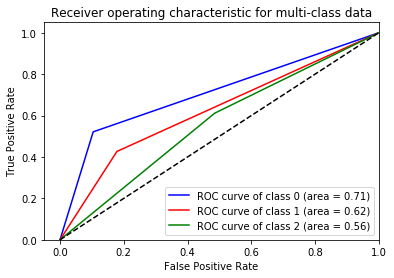

In [175]:
roc(classifier3)

#### Better Model using Gini instead of Entropy

In [176]:
#Still need to get F1, Recall, and Decision Tree visualization!!!

## Random Forest

### Regular Tree Baseline

In [177]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

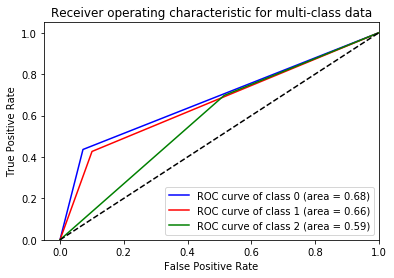

In [178]:
roc(tree_clf)

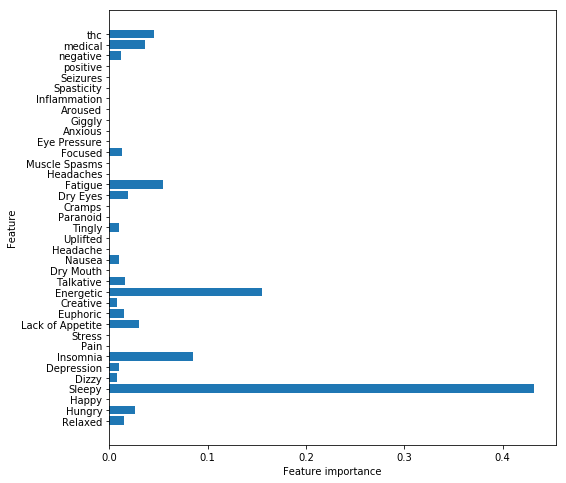

In [179]:
plot_feature_importances(tree_clf)

In [180]:
#How to with multilabel-indicator????
# pred = tree_clf.predict(X_test)
# print(confusion_matrix(y_test, pred))
# print(classification_report(X_test, pred))

print_metrics(y_pred,y_test)

Precision Score: [0.5212766  0.42666667 0.61142857]
Recall Score: [0.65333333 0.4        0.56613757]
Accuracy Score: 0.5465116279069767
F1 Score: [0.57988166 0.41290323 0.58791209]


### Forest

In [181]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [182]:
forest.score(X_train,y_train)

0.6592233009708738

In [183]:
forest.score(X_test,y_test)

0.6046511627906976

In [184]:
y_pred=forest.predict(X_test)
print_metrics(y_test,y_pred)

Precision Score: [0.8        0.71428571 0.60344828]
Recall Score: [0.5106383  0.26666667 0.8       ]
Accuracy Score: 0.6046511627906976
F1 Score: [0.62337662 0.38834951 0.68796069]


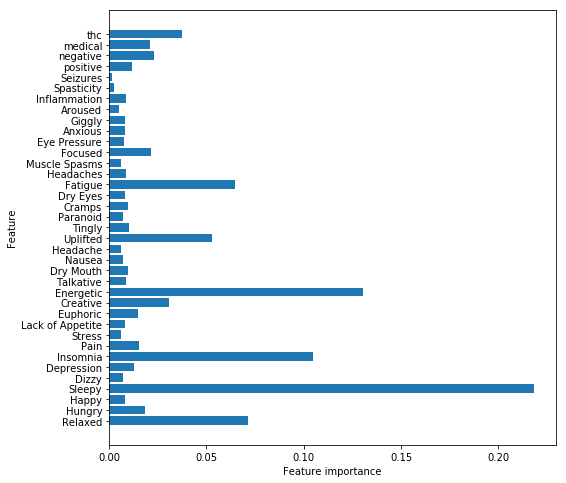

In [185]:
plot_feature_importances(forest)

In [186]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
y_pred=forest_2.predict(X_test)
print_metrics(y_test,y_pred)

Precision Score: [0.86842105 0.         0.59227468]
Recall Score: [0.35106383 0.         0.78857143]
Accuracy Score: 0.49709302325581395
F1 Score: [0.5        0.         0.67647059]


In [188]:
print(forest_2.score(X_train,y_train))
print(forest_2.score(X_test,y_test))

0.5300970873786408
0.49709302325581395


## Grid Search

In [189]:
dt_clf=DecisionTreeClassifier()
dt_cv_score=cross_val_score(dt_clf, X_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

Mean Cross Validation Score: 51.46%


In [190]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [191]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [192]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 66.28%
Mean Testing Score: 60.47%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [193]:
forest3 = RandomForestClassifier(criterion='gini', max_depth=3,min_samples_leaf=4,min_samples_split=2)
forest3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [194]:
y_pred=forest3.predict(X_test)
print_metrics(y_test,y_pred)

Precision Score: [0.78333333 0.         0.58823529]
Recall Score: [0.5        0.         0.85714286]
Accuracy Score: 0.5726744186046512
F1 Score: [0.61038961 0.         0.69767442]


In [195]:
print(forest3.score(X_train,y_train))
print(forest3.score(X_test,y_test))

0.5883495145631068
0.5726744186046512
